# Autofocus


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from datetime import datetime
import joblib

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)

In [15]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = {c: [v[0] / 2, v[1] / 2] for (c, v) in configs.DEFAULT_MOVEMENT_RANGES.items()}

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["log_weighted_sum_intensity", "peak_distance", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [16]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [27]:
def print_beam_attributes(loss_parameters, hist, dw, title, calc_params = None):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda dw: -np.log(opt_common._get_peak_intensity_from_dw(dw))
    }
    

    wsum_fn = lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2)
    if calc_params is not None:
        wsum_fn = lambda hist: opt_common._get_weighted_sum_intensity_from_hist(hist, 2, 
                                                                                calculate_over_noise=calc_params.calculate_over_noise,
                                                                                noise_threshold=calc_params.noise_threshold)
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(wsum_fn(hist))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [28]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 512,
    nbins_v = 512,
    use_denoised = False,
    random_seed = 111,
    add_noise = True,
    calculate_over_noise= True,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=20
   )

xrange_plot = [x/4 for x in cp.xrange]
yrange_plot = [y/4 for y in cp.yrange]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot)#, nbins_h = cp.nbins_h // 4, nbins_v = cp.nbins_v // 4)


In [29]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=512, nbins_v=512, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=None, percentage_fluctuation=20, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [30]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-12.5, 12.5], 'hb_2': [-12.5, 12.5], 'hb_pitch': [-0.001, 0.001], 'hb_trans': [-0.015, 0.015], 'vb_bender': [-10.0, 10.0], 'vb_pitch': [-0.001, 0.001], 'vb_trans': [-0.015, 0.015]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['log_weighted_sum_intensity', 'peak_distance', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [31]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


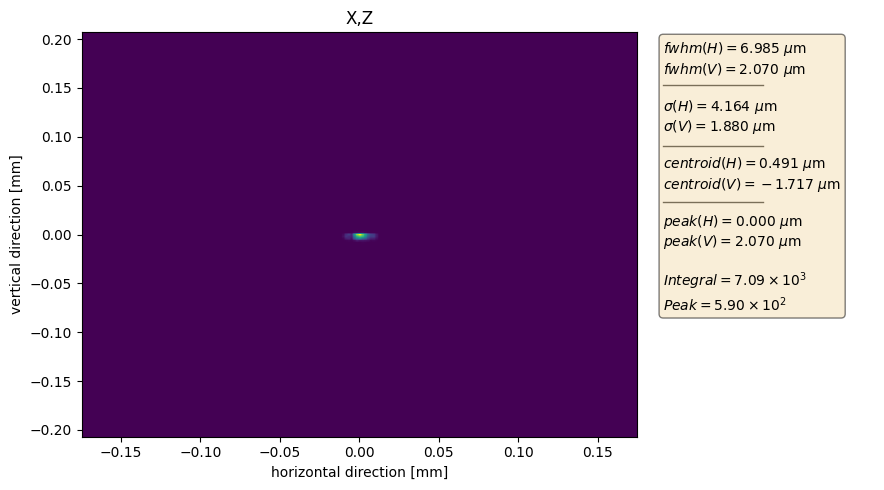

In [32]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [33]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam", calc_params=cp)

Focused beam system log_weighted_sum_intensity: -1.709e+00
Focused beam system peak_distance: 2.126e-03
Focused beam system negative_log_peak_intensity: -7.113e+00


In [34]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [35]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-175.10000000000002, -153.5, 0.17178733853924988, -0.015, 411.4, 0.17146733853924986, 0.013000000000000001]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-7.147935894261015, 7.4802778882753636, -7.241897899734216e-05, -0.007522081520596394, -7.57506091376831, -0.0004183163121914468, 0.01297745633871529]


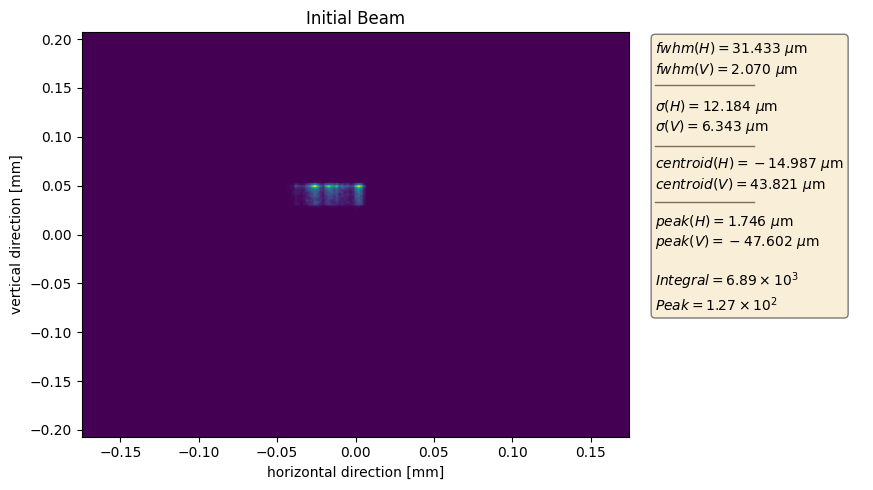

Perturbed beam system log_weighted_sum_intensity: 2.778e+00
Perturbed beam system peak_distance: 5.671e-02
Perturbed beam system negative_log_peak_intensity: -5.567e+00


In [36]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

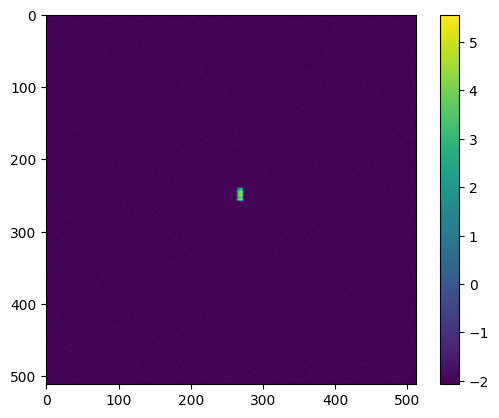

In [37]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [38]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### WITH MOO THRESHOLDS

In [39]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

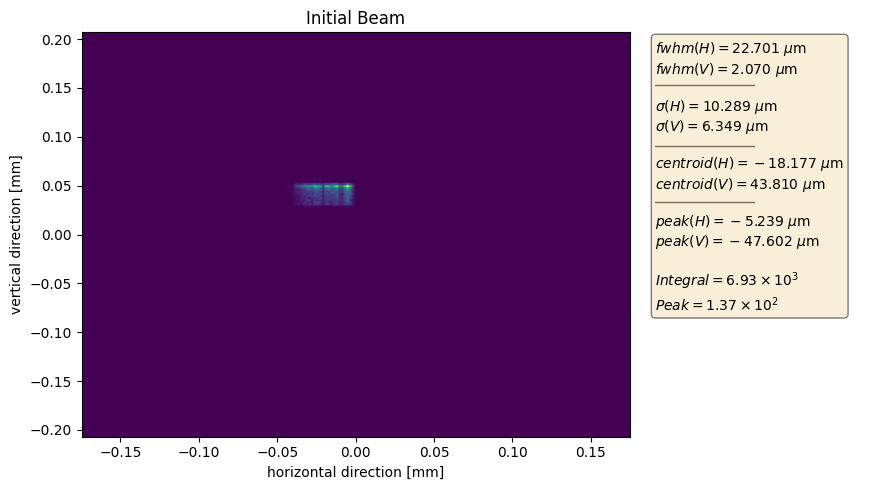

In [40]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [41]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam", calc_params=cp)

Perturbed beam system log_weighted_sum_intensity: 2.810e+00
Perturbed beam system peak_distance: 5.054e-02
Perturbed beam system negative_log_peak_intensity: -5.369e+00


In [42]:
opt_params = OptimizationParameters()

In [43]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

In [44]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [45]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-01-22 12:35:51,748] A new study created in memory with name: no-name-342bcec3-55c3-4d81-ac95-751c71a661eb


In [46]:
opt_trial.trials(50)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_1' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_2' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 12:35:52,266] Trial 0 finished with values: [2.8104918427572283, 0

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:52,658] Trial 1 finished with values: [4.197485548835543, 0.10092810166010219, -5.694478546783336] and parameters: {'hb_1': 2.5, 'hb_2': -8.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': 0.008, 'vb_bender': -4.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.0144}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:53,056] Trial 2 finished with values: [4.875085858292, 0.13607200517163945, -5.284097480491897] and parameters: {'hb_1': -2.5, 'hb_2': -6.5, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.014700000000000001, 'vb_bender': -6.0, 'vb_pitch': -0.00084, 'vb_trans': 0.005000000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:53,447] Trial 3 finished with values: [1.5592727909727513, 0.023812941179168545, -4.860333881910208] and parameters: {'hb_1': 3.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0115, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.008800000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:53,835] Trial 4 finished with values: [4.043860198301388, 0.1067781897316496, -6.121366630613004] and parameters: {'hb_1': 8.5, 'hb_2': 8.5, 'hb_pitch': 0.0009, 'hb_trans': 0.0023, 'vb_bender': 7.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': -0.014199999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:54,233] Trial 5 finished with values: [4.3537965175512365, 0.11533298382862325, -6.189971690534066] and parameters: {'hb_1': -1.5, 'hb_2': -10.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': 0.0059000000000000025, 'vb_bender': 1.0, 'vb_pitch': -0.00046, 'vb_trans': 0.0149}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:54,624] Trial 6 finished with values: [3.807239106982059, 0.07366007173226581, -5.483008654437906] and parameters: {'hb_1': -9.5, 'hb_2': 3.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.002899999999999998, 'vb_bender': 5.0, 'vb_pitch': -0.00035999999999999997, 'vb_trans': -0.002999999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:55,013] Trial 7 finished with values: [3.0073777894293086, 0.0618915116907024, -4.713219754911847] and parameters: {'hb_1': -4.5, 'hb_2': 11.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': 0.009400000000000002, 'vb_bender': -10.0, 'vb_pitch': 0.0008800000000000001, 'vb_trans': 0.013500000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:55,411] Trial 8 finished with values: [4.9265332082499045, 0.15699145606051615, -4.883114496404284] and parameters: {'hb_1': 7.5, 'hb_2': -0.5, 'hb_pitch': 0.0009, 'hb_trans': -0.0024999999999999988, 'vb_bender': -4.0, 'vb_pitch': -0.00098, 'vb_trans': -0.0139}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:35:55,802] Trial 9 finished with values: [5.038483358888728, 0.1467310752298584, -6.274061881594116] and parameters: {'hb_1': -11.5, 'hb_2': -9.5, 'hb_pitch': -0.001, 'hb_trans': -0.008299999999999998, 'vb_bender': 1.0, 'vb_pitch': -0.00066, 'vb_trans': -0.0097}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:02,626] Trial 10 finished with values: [1.3390194625356184, 0.024684127847719096, -4.905012165710795] and parameters: {'hb_1': 2.5, 'hb_2': -4.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': -0.0091, 'vb_bender': -6.0, 'vb_pitch': 0.00068, 'vb_trans': 0.007100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:11,073] Trial 11 finished with values: [1.1975534769172844, 0.02172066685841879, -4.597258697122222] and parameters: {'hb_1': 2.5, 'hb_2': -0.5, 'hb_pitch': 0.0, 'hb_trans': -0.0073999999999999995, 'vb_bender': -8.0, 'vb_pitch': 0.00058, 'vb_trans': 0.005300000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 12:36:18,447] Trial 12 finished with values: [0.8291492871315089, 0.010630760875037412, -4.86798306938036] and parameters: {'hb_1': 2.5, 'hb_2': -0.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.008899999999999998, 'vb_bender': -2.0, 'vb_pitch': 0.0006400000000000002, 'vb_trans': 0.0069}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:26,183] Trial 13 finished with values: [0.5760603415444421, 0.013267907475348662, -5.511481328805581] and parameters: {'hb_1': 2.5, 'hb_2': -1.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.008499999999999999, 'vb_bender': 3.0, 'vb_pitch': 0.0006000000000000001, 'vb_trans': 0.006700000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:34,347] Trial 14 finished with values: [0.6395638067943045, 0.002126152175007474, -5.683130315406711] and parameters: {'hb_1': 2.5, 'hb_2': 0.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.008, 'vb_bender': 7.0, 'vb_pitch': 0.0006400000000000002, 'vb_trans': 0.006000000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:41,304] Trial 15 finished with values: [0.41155891196261996, 0.002126152175007474, -5.785986855251145] and parameters: {'hb_1': 2.5, 'hb_2': -1.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.007799999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000002, 'vb_trans': 0.0059000000000000025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:52,066] Trial 16 finished with values: [1.6187668400345603, 0.01516932073713175, -6.468336751435692] and parameters: {'hb_1': 2.5, 'hb_2': -4.5, 'hb_pitch': 0.00030000000000000014, 'hb_trans': -0.0060999999999999995, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000002, 'vb_trans': 0.0046}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:36:59,364] Trial 17 finished with values: [1.0509232272150073, 0.01257500021841604, -5.936917038583812] and parameters: {'hb_1': 2.5, 'hb_2': -1.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.007199999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0007200000000000002, 'vb_trans': 0.005200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:37:12,151] Trial 18 finished with values: [0.48538290648446514, 0.011457334902641609, -6.414644288376548] and parameters: {'hb_1': 2.5, 'hb_2': -4.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.006799999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0005, 'vb_trans': 0.005000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:37:26,044] Trial 19 finished with values: [0.22711217073884887, 0.018478863575659882, -6.161858330499064] and parameters: {'hb_1': 4.5, 'hb_2': -4.5, 'hb_pitch': 0.0, 'hb_trans': -0.006299999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0006000000000000001, 'vb_trans': 0.006400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:37:41,253] Trial 20 finished with values: [0.31156191526611987, 0.018478863575659882, -6.275768765703772] and parameters: {'hb_1': 0.5, 'hb_2': -4.5, 'hb_pitch': 0.0, 'hb_trans': -0.008299999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.00058, 'vb_trans': 0.0045000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:37:56,754] Trial 21 finished with values: [0.8303878741353005, 0.014883065225052403, -6.1473040376857355] and parameters: {'hb_1': 3.5, 'hb_2': -3.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.009, 'vb_bender': 10.0, 'vb_pitch': 0.0004800000000000002, 'vb_trans': 0.0039000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:38:12,321] Trial 22 finished with values: [0.3555075158460873, 0.011457334902641609, -6.378166817316428] and parameters: {'hb_1': 0.5, 'hb_2': -3.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.005099999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.007000000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:38:24,663] Trial 23 finished with values: [0.20099824738584673, 0.01257500021841604, -6.418044178024816] and parameters: {'hb_1': 1.5, 'hb_2': -2.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.004999999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': 0.0057}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:38:39,851] Trial 24 finished with values: [0.5596183653298171, 0.010630760875037412, -6.0848610890166634] and parameters: {'hb_1': 1.5, 'hb_2': -0.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.005599999999999999, 'vb_bender': 9.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0057}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applica

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:39:13,071] Trial 25 finished with values: [0.08252309144258746, 0.010764786597660133, -6.178169574406043] and parameters: {'hb_1': 1.5, 'hb_2': -2.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.005999999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0006000000000000001, 'vb_trans': 0.0069}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:39:29,664] Trial 26 finished with values: [1.1394940971938525, 0.013281117301726797, -6.100041707904138] and parameters: {'hb_1': 1.5, 'hb_2': -3.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.007099999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0005, 'vb_trans': 0.007100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:39:48,123] Trial 27 finished with values: [-0.04928686593984288, 0.010764786597660133, -6.257564415912057] and parameters: {'hb_1': 1.5, 'hb_2': -2.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.004199999999999999, 'vb_bender': 9.0, 'vb_pitch': 0.0006600000000000002, 'vb_trans': 0.004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:39:59,016] Trial 28 finished with values: [-0.31273376046837525, 0.009734250381676215, -6.38860929925506] and parameters: {'hb_1': 1.5, 'hb_2': -3.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.004399999999999999, 'vb_bender': 10.0, 'vb_pitch': 0.0006200000000000001, 'vb_trans': 0.005400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:40:16,334] Trial 29 finished with values: [-0.23425555601512996, 0.0070454294959375096, -6.322607143063268] and parameters: {'hb_1': 1.5, 'hb_2': -4.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.0055, 'vb_bender': 10.0, 'vb_pitch': 0.00058, 'vb_trans': 0.0039000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasy

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:40:52,589] Trial 30 finished with values: [-0.6870099508293438, 0.002126152175007474, -6.745552942031838] and parameters: {'hb_1': -0.5, 'hb_2': -6.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.003999999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0006200000000000001, 'vb_trans': 0.004900000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:40:55,936] Trial 31 finished with values: [5.096419107222885, 0.15870213088760532, -5.167714402681854] and parameters: {'hb_1': -5.5, 'hb_2': 1.5, 'hb_pitch': -0.0005, 'hb_trans': 0.010900000000000003, 'vb_bender': -5.0, 'vb_pitch': -0.00096, 'vb_trans': 0.005000000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:40:59,570] Trial 32 finished with values: [3.975505053887795, 0.1032454748016425, -6.044196798001547] and parameters: {'hb_1': 11.5, 'hb_2': -3.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.005099999999999999, 'vb_bender': 9.0, 'vb_pitch': 0.0, 'vb_trans': 0.003100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:03,058] Trial 33 finished with values: [3.8358604088553627, 0.0821082563590843, -6.177331782990447] and parameters: {'hb_1': -11.5, 'hb_2': -5.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': -0.0096, 'vb_bender': 1.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.0063999999999999994}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:06,406] Trial 34 finished with values: [2.6451146718115237, 0.055506136305840476, -4.506300269559251] and parameters: {'hb_1': 9.5, 'hb_2': 0.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.0037999999999999996, 'vb_bender': -4.0, 'vb_pitch': 0.0001200000000000001, 'vb_trans': 0.007800000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:09,554] Trial 35 finished with values: [3.7817788802726633, 0.07572955560037749, -6.547334774222643] and parameters: {'hb_1': 12.5, 'hb_2': -7.5, 'hb_pitch': 0.0006000000000000001, 'hb_trans': -0.0002999999999999982, 'vb_bender': 3.0, 'vb_pitch': 0.0, 'vb_trans': 0.006500000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:12,894] Trial 36 finished with values: [3.1934109295795983, 0.06939567639957192, -4.720690389539793] and parameters: {'hb_1': -8.5, 'hb_2': 6.5, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.013800000000000003, 'vb_bender': -7.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': -0.011699999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:16,246] Trial 37 finished with values: [1.7691306246549663, 0.037055179381157065, -5.317062303109537] and parameters: {'hb_1': 5.5, 'hb_2': 6.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.010499999999999999, 'vb_bender': 0.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.0052}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:19,753] Trial 38 finished with values: [3.639526181856637, 0.06172061421729658, -4.371979499340449] and parameters: {'hb_1': -11.5, 'hb_2': -1.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.013, 'vb_bender': -9.0, 'vb_pitch': 0.0008000000000000001, 'vb_trans': 0.013400000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:23,300] Trial 39 finished with values: [4.508647931854305, 0.11283654312534369, -5.571842083447299] and parameters: {'hb_1': -9.5, 'hb_2': -2.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.0107, 'vb_bender': -1.0, 'vb_pitch': -0.0007, 'vb_trans': -0.0136}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:26,860] Trial 40 finished with values: [0.38980933221625985, 0.009106849490444066, -6.669455334070877] and parameters: {'hb_1': -3.5, 'hb_2': -10.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.004699999999999999, 'vb_bender': 5.0, 'vb_pitch': 0.0006400000000000002, 'vb_trans': -0.0031999999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:31,271] Trial 41 finished with values: [-0.6869188920126095, 0.002126152175007474, -6.8997214425412094] and parameters: {'hb_1': -0.5, 'hb_2': -9.5, 'hb_pitch': 0.00010000000000000005, 'hb_trans': -0.0017999999999999995, 'vb_bender': 10.0, 'vb_pitch': 0.0006400000000000002, 'vb_trans': 0.0045000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:35,008] Trial 42 finished with values: [3.9531009895395517, 0.10935702984351893, -4.511665646729064] and parameters: {'hb_1': 5.5, 'hb_2': 9.5, 'hb_pitch': 0.0008000000000000001, 'hb_trans': -0.002999999999999999, 'vb_bender': -7.0, 'vb_pitch': -7.999999999999999e-05, 'vb_trans': -0.0005999999999999981}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:38,864] Trial 43 finished with values: [4.190979317217899, 0.10804456518963182, -4.999803156969311] and parameters: {'hb_1': 0.5, 'hb_2': -4.5, 'hb_pitch': -0.0007, 'hb_trans': -0.001599999999999999, 'vb_bender': -6.0, 'vb_pitch': 0.00014000000000000015, 'vb_trans': 0.011300000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:42,840] Trial 44 finished with values: [4.0733108828116205, 0.11436786453418792, -6.086610397922958] and parameters: {'hb_1': 12.5, 'hb_2': 4.5, 'hb_pitch': 0.0009, 'hb_trans': -0.003999999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0006000000000000001, 'vb_trans': -0.0103}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:48,080] Trial 45 finished with values: [5.032095411480845, 0.16051169137173965, -5.254475651677732] and parameters: {'hb_1': 1.5, 'hb_2': -10.5, 'hb_pitch': -0.0008, 'hb_trans': -0.0002999999999999982, 'vb_bender': -10.0, 'vb_pitch': -0.00076, 'vb_trans': 0.0142}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:52,784] Trial 46 finished with values: [3.054046191519445, 0.06852031690480828, -4.909058601068186] and parameters: {'hb_1': -1.5, 'hb_2': -12.5, 'hb_pitch': -0.00019999999999999998, 'hb_trans': -0.008799999999999999, 'vb_bender': -8.0, 'vb_pitch': -0.00019999999999999998, 'vb_trans': -0.0126}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:41:56,794] Trial 47 finished with values: [4.418998986755695, 0.11490800505027395, -4.98140313181928] and parameters: {'hb_1': 12.5, 'hb_2': 3.5, 'hb_pitch': -0.00030000000000000003, 'hb_trans': 0.012100000000000003, 'vb_bender': -6.0, 'vb_pitch': -0.0005, 'vb_trans': 0.011600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:42:00,284] Trial 48 finished with values: [1.778652493741898, 0.03709774509373903, -4.4125595619495765] and parameters: {'hb_1': -0.5, 'hb_2': 8.5, 'hb_pitch': 0.0002000000000000001, 'hb_trans': -0.0019999999999999983, 'vb_bender': -9.0, 'vb_pitch': 0.00044000000000000007, 'vb_trans': 0.011500000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-01-22 12:42:04,527] Trial 49 finished with values: [3.6400274311404623, 0.0675254112731092, -6.482393804400997] and parameters: {'hb_1': -11.5, 'hb_2': -5.5, 'hb_pitch': -9.999999999999994e-05, 'hb_trans': 0.0051, 'vb_bender': 10.0, 'vb_pitch': -0.00011999999999999999, 'vb_trans': 0.007300000000000001}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37871/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

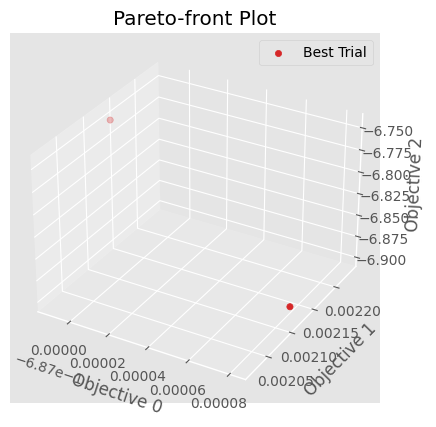

In [48]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [49]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

nan 0.5030780505556157
nan 0.5031238623333758


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_37871/2890865355.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs['ws'])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-0.6870099508293438, 0.002126152175007474, -6.745552942031838]


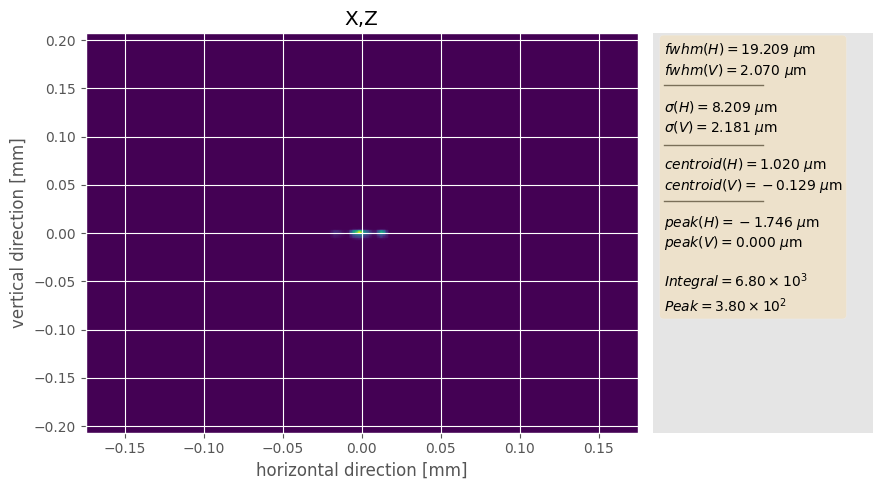

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-0.6869188920126095, 0.002126152175007474, -6.8997214425412094]


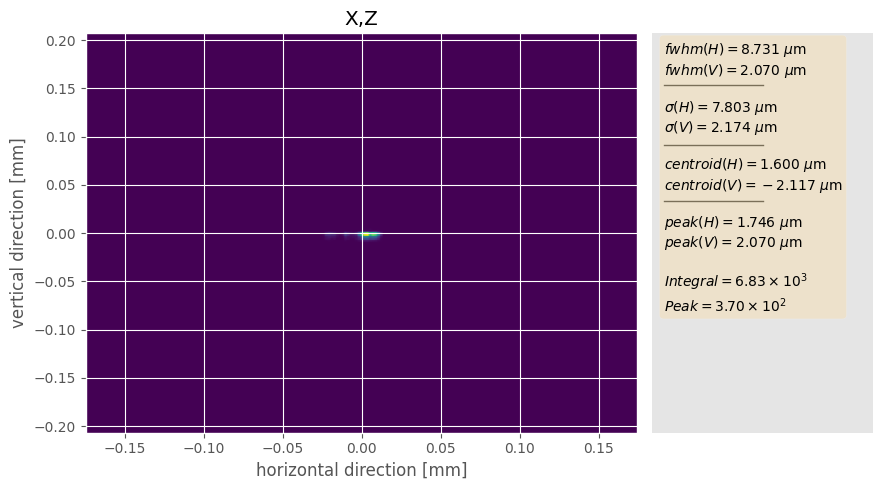

In [50]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-0.6870099508293438, 0.002126152175007474, -6.745552942031838]


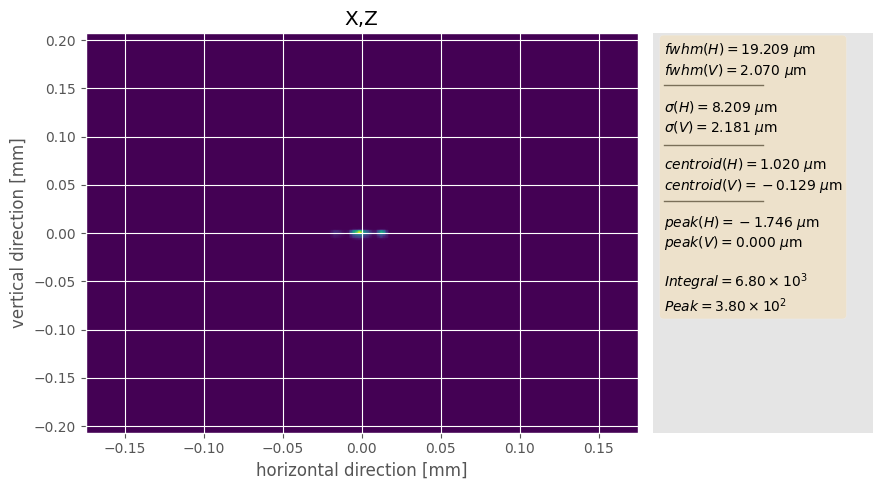

In [51]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

2
[0.5 nan 0.5]
1
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.


/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:340: RuntimeWarning: invalid value encountered in true_divide
  closeness = s_minus / (s_plus + s_minus)


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
[-0.6869188920126095, 0.002126152175007474, -6.8997214425412094]


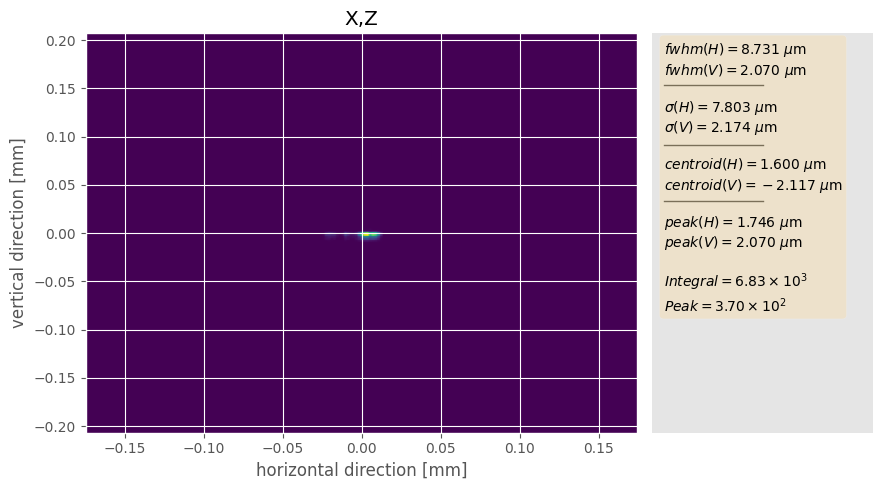

In [52]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

In [59]:
opt_trial.trials(50)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/samplers/_partial_fixed.py:109: UserWarning: Fixed parameter 'hb_1' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/samplers/_partial_fixed.py:109: UserWarning: Fixed parameter 'hb_2' with value 0.0 is out of range for distribution FloatDistribution(high=12.5, log=False, low=-12.5, step=1.0).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-0.015, 0.014900000000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.015, 0.0149].
  warnings.warn(
[I 2023-01-22 12:10:10,602] Trial 27 finished with values:

KeyboardInterrupt: 

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35131/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

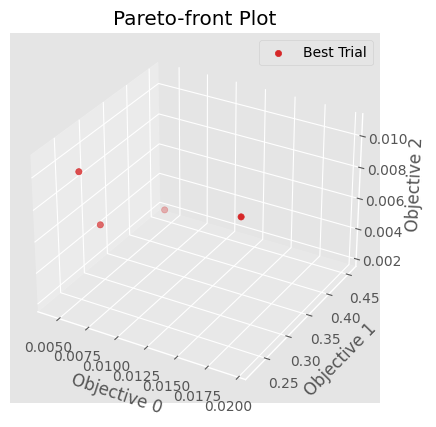

In [61]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [62]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['ws'])

-9.981867451434915 1.246816117983465
-11.103674825592698 1.248786231659959
-12.404106487397252 1.5740887467647389
-11.452516771582054 1.298538022835249


[0.01946850076335243, 0.2205931963086094, 0.010764786597660133]


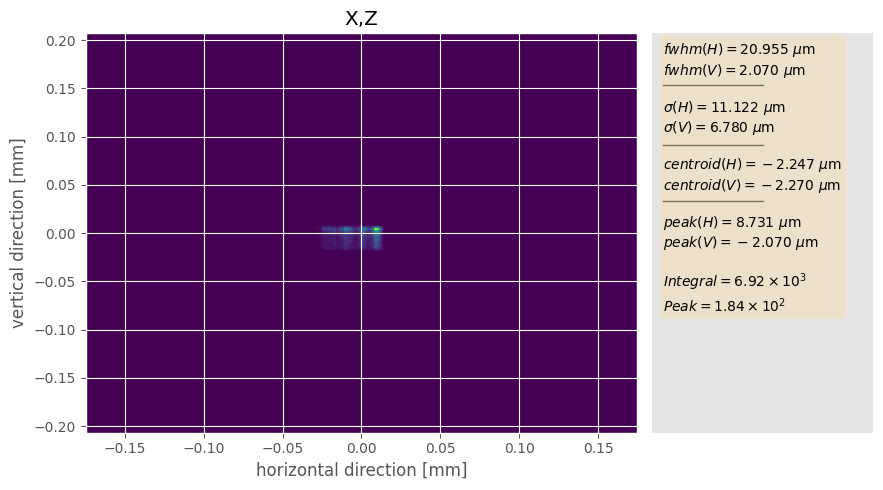

[0.006375019148255531, 0.2221720649020278, 0.010630760875037412]


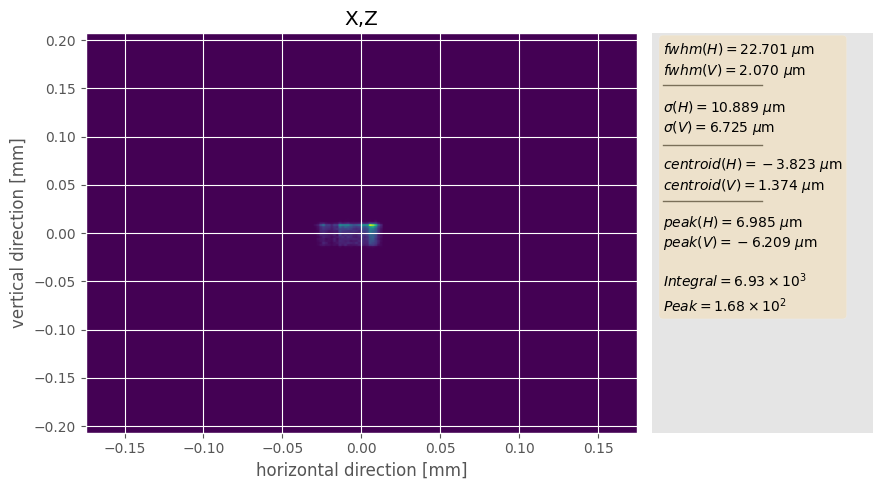

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


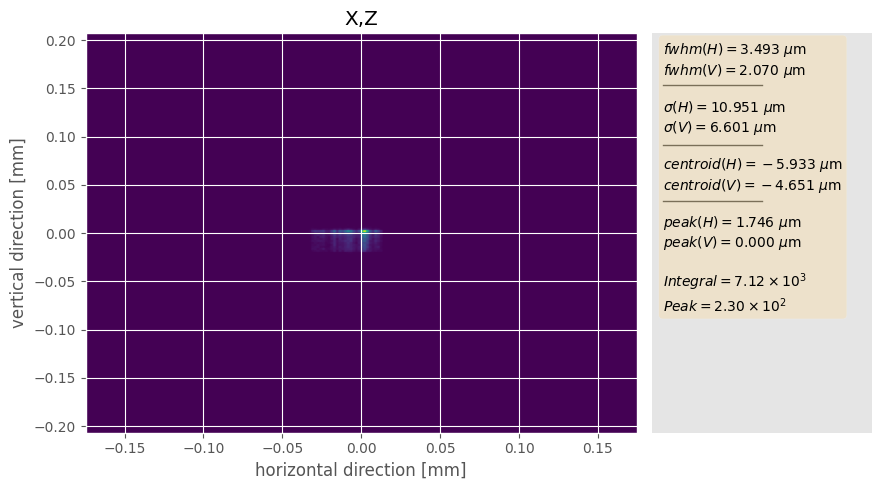

[0.006375019148255531, 0.26123903381382374, 0.006378456525022422]


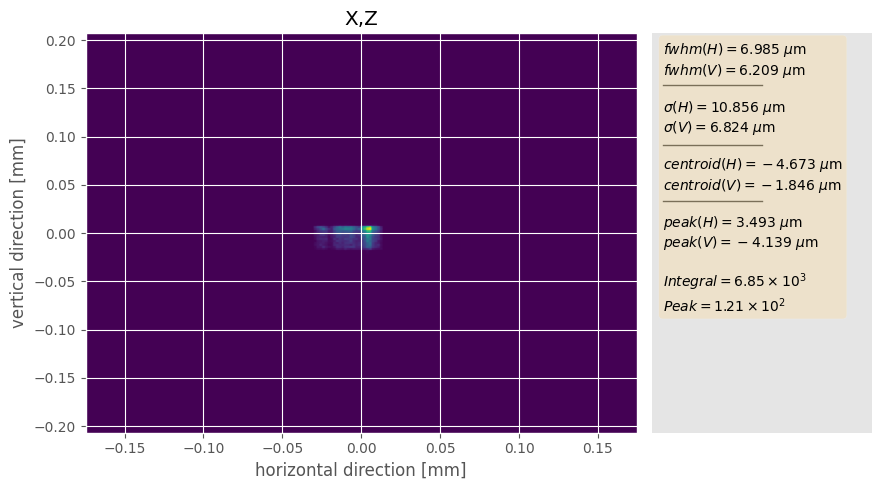

In [63]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)
    
    opt_common.plot_distribution(
        photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    #plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    #print(vals)
    #plt.figure(figsize=[5, 5])
    #plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    #plt.axis("off")
    #plt.show()

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


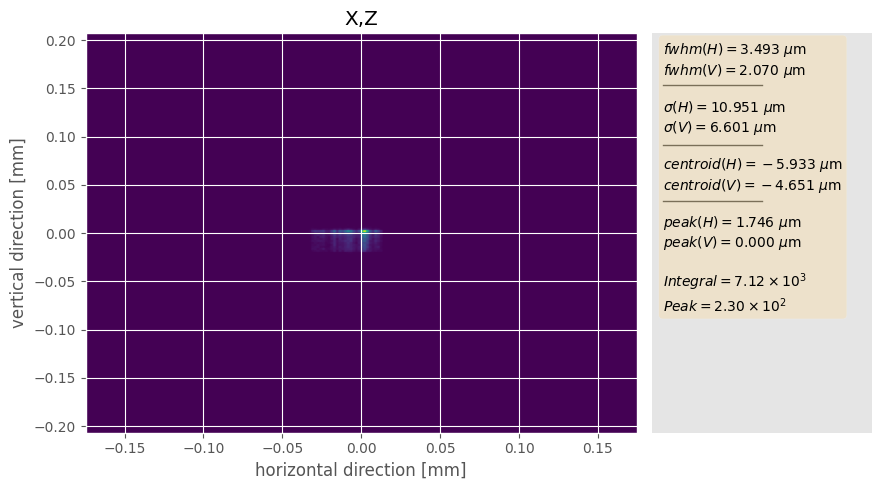

In [64]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

[0.004252304350014948, 0.4536765313566668, 0.002126152175007474]


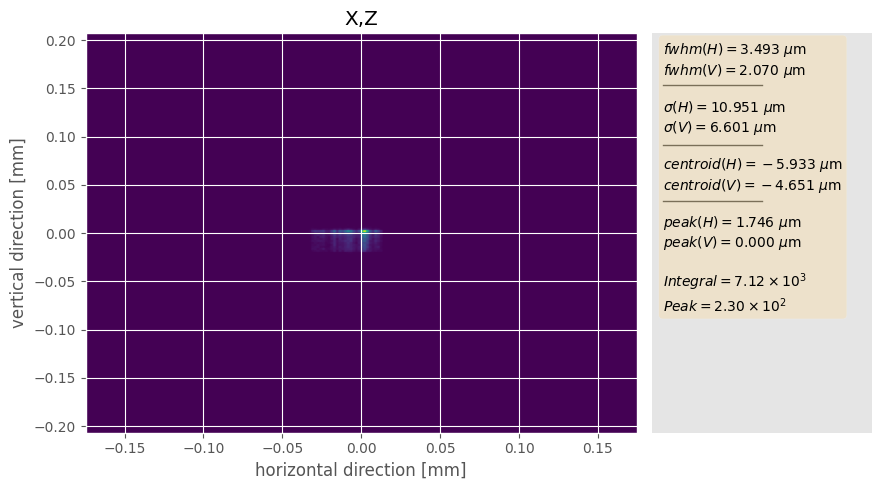

In [65]:
params, values = opt_trial.select_best_trial_params(opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.TOPSIS)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(
    photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)